### Lasso Regression - performance in variable selection and coefficient estimation

In this notebook, we shall delve into the practical application of the Least Absolute Shrinkage and Selection Operator, commonly abbreviated as LASSO. Our objective is to assess its efficacy in two separate scenarios: one involving irregular coefficients and another with regular coefficients.

Though ridge regression has a great many applications and uses, there is one thing to note: it does not perform variable selection.

Lasso regression aids in variable selection and can entirely nullify certain coefficients. However, does this methodology perform equally effectively in the two aforementioned scenarios?
 
we will generate artificial datasets to illustrate and evaluate the functionality of Lasso regression. One dataset will be intentionally designed to exhibit multicollinearity, a situation where the explanatory variables are highly correlated with one another, posing a challenge for traditional regression techniques. The other dataset will be structured with a regular matrix of explanatory variables, representing a scenario where relationships between variables adhere to more conventional patterns. By applying Lasso regression to these two distinct datasets, we aim to examine its performance in variable selection and coefficient estimation under both scenarios, shedding light on its versatility and effectiveness in handling diverse real-world data complexities.

In [1907]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

RSEED = 42

# define figure size
plt.rcParams['figure.figsize'] = (10, 7)

In [1908]:
# Create Variables
np.random.seed(RSEED)

# Independent Variables
X1 = 5 * np.random.rand(500,1)
X2 = np.random.normal(30, 20, (500,1))
X3 = np.random.gamma(2, 5, (500, 1))
X4 = -0.5 * np.random.rand(500,1) + 24
X5 = 3 * np.random.normal(50, 60, (500,1))
X6 = np.random.normal(4, 15, (500,1))

# Variables that are linear combination of X1 - X6 variables
X7 = 4 + 0.95 * X1
X8 = 0.98 * X5
X9 = -0.99 * X3
X10 = 18 - 0.80 * X6
X11 = 0.75 * X1
X12 = 0.97 * X2

# Variables to add extra complexity to the data
X13 = 0.25 * X2**2
X14 = 10 + X4**3
X15 = -0.19 * X3*X5
X16 = np.random.pareto(2, (500, 1))
X17 = np.random.exponential(scale=2, size=(500, 1))
X18 = np.random.normal(10, 25, (500,1)) + 13

# Dependent Variables
noise1 = np.random.normal(0, 50, (500, 1)) 
y1 = 10 + 2*X1 + 0.5*X3 + 20*X4 + 3*X5 + 40*X6 + 22*X7 + 0.85*X8 + 6.5*X9 + 12*X10 + 2*X12 + 23*X13 + 4*X18 + noise1
noise2 = np.random.normal(0, 25, (500, 1)) 
y2 = 34 + 12*X1 + 5*X3 + 13*X4 + noise2



We are aware of the true data generating processes behind y1 and y2. However, for the sake of exploration, let us hypothetically assume that we do not possess this knowledge and attempt to discover it using linear regression methods.

In [1909]:
# Create a DataFrame with multicolinearity
data = {
    'X1': X1.flatten(),
    'X2': X2.flatten(),
    'X3': X3.flatten(),
    'X4': X4.flatten(),
    'X5': X5.flatten(),
    'X6': X6.flatten(),
    'X7': X7.flatten(),
    'X8': X8.flatten(),
    'X9': X9.flatten(),
    'X10': X10.flatten(),
    'X11': X11.flatten(),
    'X12': X12.flatten(),
    'X13': X13.flatten(),
    'X14': X14.flatten(),
    'X15': X15.flatten(),
    'X16': X16.flatten(),
    'X17': X17.flatten(),
    'X18': X18.flatten(),
    'y1': y1.flatten(),
    'y2': y2.flatten()
}

df = pd.DataFrame(data)

df.head()


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,y1,y2
0,1.872701,36.835120,12.699421,23.956454,34.532356,13.331050,5.779066,33.841709,-12.572426,7.335160,1.404525,35.730066,339.206507,13758.888300,-83.322774,1.586948,2.210528,29.072050,9286.071035,445.524466
1,4.753572,67.523417,6.222611,23.691467,237.817011,23.934000,8.515893,233.060671,-6.160385,-1.147200,3.565179,65.497714,1139.852954,13307.679039,-281.170127,0.119104,3.205479,-29.052468,28650.566816,471.039927
2,3.659970,49.008477,14.830738,23.943081,474.782660,9.802128,7.476971,465.287007,-14.682431,10.158298,2.744977,47.538222,600.457699,13735.876709,-1337.861674,2.905328,5.398764,36.828729,16980.434524,457.807315
3,2.993292,18.461927,12.055376,23.827388,115.637317,20.364706,6.843628,113.324571,-11.934822,1.708235,2.244969,17.908069,85.210686,13537.867284,-264.869751,0.793416,0.040687,9.294993,3853.816271,441.686683
4,0.780093,12.031707,20.817823,23.746294,279.556430,34.184057,4.741089,273.965301,-20.609645,-9.347245,0.585070,11.670755,36.190491,13400.214158,-1105.753702,1.378750,0.333961,71.086145,3978.096066,460.966980


In [1910]:
# Calculate the correlation coefficients for y1 and y2 with independent variables
correlation_y1 = df.corr()['y1'].drop(['y1', 'y2'])
correlation_y2 = df.corr()['y2'].drop(['y1', 'y2'])

# Create a DataFrame for the correlation coefficients
correlation_df = pd.DataFrame({'y1 Correlation with': correlation_y1, 'y2 Correlation with': correlation_y2})

# Display the table
print(correlation_df)

     y1 Correlation with  y2 Correlation with
X1              0.082982             0.346692
X2              0.915746             0.008592
X3              0.013585             0.761298
X4             -0.054431            -0.003016
X5              0.140592             0.043481
X6              0.149230             0.035621
X7              0.082982             0.346692
X8              0.140592             0.043481
X9             -0.013585            -0.761298
X10            -0.149230            -0.035621
X11             0.082982             0.346692
X12             0.915746             0.008592
X13             0.995094             0.026216
X14            -0.054286            -0.003112
X15            -0.106866            -0.404514
X16             0.005983            -0.027303
X17             0.061479            -0.054563
X18            -0.062639            -0.008441


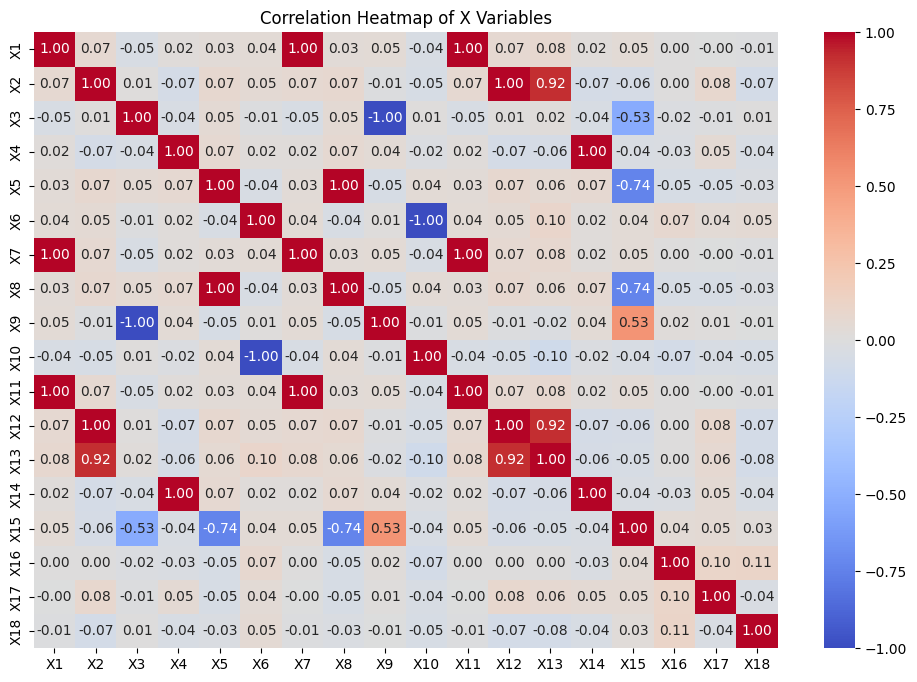

In [1911]:
# Calculate the correlation matrix for X variables
correlation_matrix_X = df.drop(['y1', 'y2'], axis=1).corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_X, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of X Variables")
plt.show()

In [1912]:
# define features for the model 1
features_1 = df.columns.tolist()
features_1.remove('y1')
features_1.remove('y2')
features_1.remove('X1')
features_1.remove('X7')
X_1 = df[features_1]
y_1 = df['y1']

We opted to exclude variables X1 and X7 from our analysis in model 1. Consider the scenario where we are estimating wages for a particular cohort. Some variables, like 'ability,' may remain unobservable. Although ability plays a pivotal role in the true data generation process of wages, we lack access to direct measurements of it. Simultaneously, we retained X11, a variable correlated with X1. In the context of wage estimation, X11 could be analogous to IQ test results, serving as a proxy for ability. An intriguing question arises: Will X11 capture the influence of X1?

Recall that, in linear regression, we estimate the coefficients using the following formula in matrix notation:

$$
b = (X^T X)^{-1} X^T y
$$

Moreover, If we have collinearity problem, some of the eigenvalues of  $(X^T X)^{-1}$ would be equal to 0. 

In the case of near-perfect collinearity, some eigenvalues will be very close to 0. 

Let us assess the regularity of X_1. We deliberately seek it to exhibit irregularity.

In [1913]:
matrix_1 = X_1.to_numpy()

# Calculate the inverse of the matrix
try:
    inverse_matrix = np.linalg.inv(matrix_1.T.dot(matrix_1))
    print("Inverse Matrix exists")
except np.linalg.LinAlgError:
    print("Matrix is not invertible")

M_1 = np.linalg.inv(matrix_1.T.dot(matrix_1))
eigenvalues = np.linalg.eigvals(M_1)
print('Eigenvalues of (X_1^T X_1)^{-1}:  ', eigenvalues)

Inverse Matrix exists
Eigenvalues of (X_1^T X_1)^{-1}:   [ 1.63479519e+10+0.00000000e+00j -1.24777915e+10+0.00000000e+00j
  6.99209738e+08+0.00000000e+00j  6.91106842e+03+0.00000000e+00j
  1.35168147e-02+0.00000000e+00j  1.63068409e-03+0.00000000e+00j
  6.80682228e-04+0.00000000e+00j  5.13964644e-04+0.00000000e+00j
  4.04310076e-05+0.00000000e+00j  1.66673285e-05+0.00000000e+00j
  5.33716620e-06+0.00000000e+00j  3.19138370e-06+0.00000000e+00j
  1.07670405e-07+0.00000000e+00j  1.44384165e-08+2.42403678e-09j
  1.44384165e-08-2.42403678e-09j  2.31983670e-11+0.00000000e+00j]


Eventhough $(X_1^T X_1)^{-1}$ is invertible, many eigenvalues are very close to 0. As a reminder, if we have multicollinearity, our OLS coefficients will have large variance. The fit will be unstable, and it will become very sensitive to small perturbations. Small changes in  $y$ can lead to large changes in the coefficients.

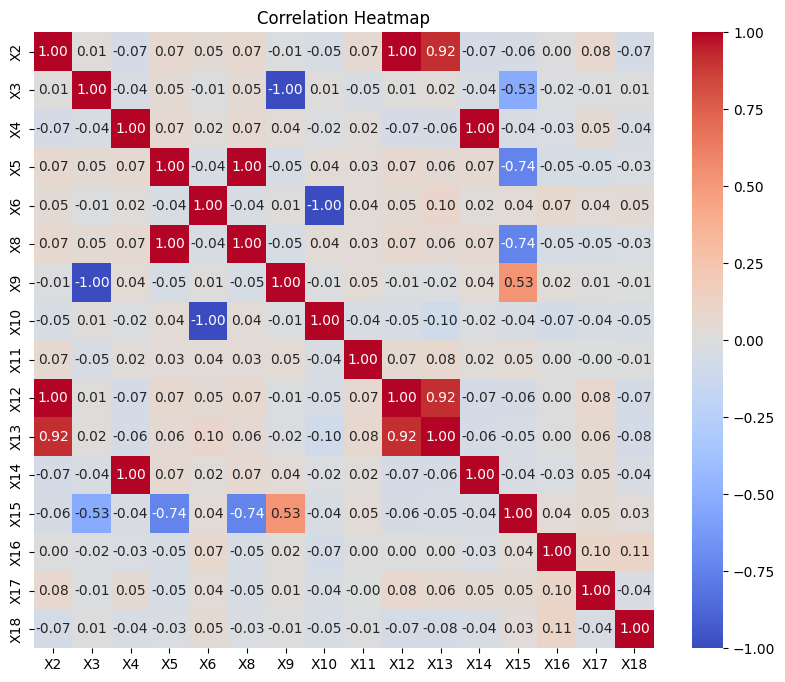

In [1914]:
corr_matrix_1 = X_1.corr()

plt.figure(figsize=(10, 8)) 
sns.heatmap(corr_matrix_1, annot=True, cmap='coolwarm', fmt=".2f")  
plt.title("Correlation Heatmap")  
plt.show()  

We can clearly observe that some variables in X_1 exhibit very high correlation.

In [1915]:
# define features for the model 2
features_2 = df.columns.tolist()
features_2.remove('y1')
features_2.remove('y2')
columns_to_remove = ['X1','X7','X8', 'X9', 'X10', 'X12', 'X13', 'X14', 'X15']
features_2 = [col for col in features_2 if col not in columns_to_remove]

X_2 = df[features_2]
y_2 = df['y2']

In Model 2, we preserve all uncorrelated variables, excluding X1. Similarly, we maintain X11 for the same rationale as in Model 1.

In [1916]:
matrix_2 = X_2.to_numpy()


try:
    inverse_matrix = np.linalg.inv(matrix_2.T.dot(matrix_2))
    print("Inverse Matrix exists")
except np.linalg.LinAlgError:
    print("Matrix is not invertible")

M_2 = np.linalg.inv(matrix_2.T.dot(matrix_2))
eigenvalues_2 = np.linalg.eigvals(M_2)
print(eigenvalues_2)

Inverse Matrix exists
[1.62273094e-03 6.80114124e-04 5.17130395e-04 5.01105974e-05
 1.62412320e-05 8.74880941e-06 3.46193570e-06 1.41044010e-06
 3.63806958e-08]


Note that random variables, by their nature, can introduce additional variability and fluctuations into the data. In the case of regression analysis, this can sometimes lead to multicollinearity-like behavior, even when there's no inherent deterministic multicollinearity between the variables.

But in the context of model 2, the eigenvalues appear to be more favorable. When compared to Model 1, Model 2 exhibits relatively satisfactory results in terms of coefficient regularity.

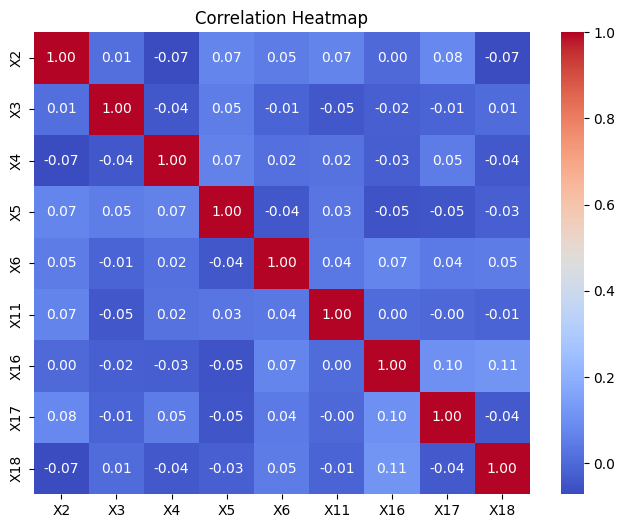

In [1917]:
corr_matrix_2 = X_2.corr()

plt.figure(figsize=(8, 6)) 
sns.heatmap(corr_matrix_2, annot=True, cmap='coolwarm', fmt=".2f")  
plt.title("Correlation Heatmap")  
plt.show()  

In [1918]:
# train-test-split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, random_state=RSEED, test_size=0.4)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, random_state=RSEED, test_size=0.4)
print(X_train_1.shape)
print(X_train_2.shape)

(300, 16)
(300, 9)


In [1919]:
# Initialize and train model
lin_reg_1 = LinearRegression()
lin_reg_2 = LinearRegression()
lin_reg_1.fit(X_train_1, y_train_1)
lin_reg_2.fit(X_train_2, y_train_2)

# Predict on test-set
y_pred_test_1 = lin_reg_1.predict(X_test_1)
y_pred_train_1 = lin_reg_1.predict(X_train_1)
y_pred_test_2 = lin_reg_2.predict(X_test_2)
y_pred_train_2 = lin_reg_2.predict(X_train_2)

# Calculate RMSE on train and test set
train_rmse_1 = np.sqrt(mean_squared_error(y_train_1, y_pred_train_1))
test_rmse_1 = np.sqrt(mean_squared_error(y_test_1, y_pred_test_1))
train_rmse_2 = np.sqrt(mean_squared_error(y_train_2, y_pred_train_2))
test_rmse_2 = np.sqrt(mean_squared_error(y_test_2, y_pred_test_2))

# Print RMSE for model 1
print("Model 1:")
print("Train RMSE:", round(train_rmse_1, 3))
print("Test RMSE:", round(test_rmse_1, 3))

# Print RMSE for model 2
print("\nModel 2:")
print("Train RMSE:", round(train_rmse_2, 3))
print("Test RMSE:", round(test_rmse_2, 3))



Model 1:
Train RMSE: 48.097
Test RMSE: 49.607

Model 2:
Train RMSE: 24.972
Test RMSE: 23.441


Note:

RMSE provides a single number that summarizes how well a predictive model is performing. Lower RMSE values indicate better model performance because they indicate that the model's predictions are closer to the actual values on average. 

$$
\text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}
$$

In [1920]:
# Get the coefficients and intercept for Model 1
intercept_1 = lin_reg_1.intercept_
coefficients_1 = lin_reg_1.coef_

# Get the coefficients and intercept for Model 2
intercept_2 = lin_reg_2.intercept_
coefficients_2 = lin_reg_2.coef_

# Create a list of feature names for Model 1 and Model 2
feature_names_1 = X_1.columns.tolist()
feature_names_2 = X_2.columns.tolist()

# Print regression equations for Model 1 and Model 2
print("\nRegression Equation for Model 1:")
equation_1 = f"y1 = {intercept_1:.1f} "
for i, coef in enumerate(coefficients_1):
    equation_1 += f"+ {coef:.3f}*{feature_names_1[i]} "
print(equation_1)

print("\nRegression Equation for Model 2:")
equation_2 = f"y2 = {intercept_2:.1f} "
for i, coef in enumerate(coefficients_2):
    equation_2 += f"+ {coef:.3f}*{feature_names_2[i]} "
print(equation_2)


Regression Equation for Model 1:
y1 = 18306.4 + 0.909*X2 + -2.808*X3 + -1101.159*X4 + 1.976*X5 + 18.698*X6 + 1.937*X8 + 2.780*X9 + -14.959*X10 + 24.069*X11 + 0.881*X12 + 23.026*X13 + 0.665*X14 + 0.015*X15 + -1.750*X16 + -1.493*X17 + 3.949*X18 

Regression Equation for Model 2:
y2 = 248.9 + -0.013*X2 + 4.974*X3 + 4.157*X4 + -0.002*X5 + 0.002*X6 + 15.835*X11 + 1.264*X16 + -1.958*X17 + -0.027*X18 


Recall True Model 1 and Model 2:

$y_{1} = 10 + 2X_{1} + 0.5X_{3} + 20X_{4} + 3X_{5} + 40X_{6} + 22X_{7} + 0.85X_{8} + 6.5X_{9} + 12X_{10} + 2X_{12} + 23X_{13} + 4X_{18} + \epsilon_{1}$
<br> $y_{2} = 34 + 12X_{1} + 5X_{3} + 13X_{4} + \epsilon_{2}$

In Model 2, linear regression demonstrates effective coefficient estimation for variables X3, X4, and  for X1 indirectly. It's important to note that X1 exhibits a high correlation with X11, which we intentionally retained in the model. This allows us to capture the influence that X1 has on the data generation process of y2.

The estimated coefficients in Model 1 lack meaningful interpretation. Undoubtedly, employing linear regression in the presence of multicollinearity is ill-advised.

In [1921]:
def coeff_info(model, total_features):
    coeff_used = np.sum(model.coef_ != 0)
    print('The model is using', coeff_used, 'out of', total_features, 'features.')
    print("The highest coefficient has a value of:", max(model.coef_.round(3)))


In [1922]:
print('Model 1:')
coeff_info(lin_reg_1, total_features=X_1.shape[1])

print('Model 2:')
coeff_info(lin_reg_2, total_features=X_2.shape[1])

Model 1:
The model is using 16 out of 16 features.
The highest coefficient has a value of: 24.069
Model 2:
The model is using 9 out of 9 features.
The highest coefficient has a value of: 15.835


Now, let's transition to Lasso regression and assess its performance in two cases: estimating Model 1 and estimating Model 2.

In [1923]:
from sklearn.linear_model import Lasso

In [1924]:
# initialize and train model with (default value) alpha = 0.5
lasso_05_1 = Lasso(alpha=0.5, max_iter=int(10e5))
lasso_05_1.fit(X_train_1,y_train_1)

# predict on test-set
y_pred_test_lasso_1 = lasso_05_1.predict(X_test_1)
y_pred_train_lasso_1 = lasso_05_1.predict(X_train_1)

# Calculate RMSE on train and test set
train_rmse_lasso_1 = np.sqrt(mean_squared_error(y_train_1, y_pred_train_lasso_1))
test_rmse_lasso_1 = np.sqrt(mean_squared_error(y_test_1, y_pred_test_lasso_1))

# Calculate R2 score on train and test set
train_r2_lasso_1 = r2_score(y_train_1, y_pred_train_lasso_1)
test_r2_lasso_1 = r2_score(y_test_1, y_pred_test_lasso_1)

# Print RMSE and R2 values
print("Lasso Model 1 (alpha=0.5):")
print("Train RMSE:", round(train_rmse_lasso_1, 3))
print("Test RMSE:", round(test_rmse_lasso_1, 3))


Lasso Model 1 (alpha=0.5):
Train RMSE: 48.11
Test RMSE: 49.5


In [1925]:
print('Model 1:')
coeff_info(lasso_05_1, total_features=X_1.shape[1])

Model 1:
The model is using 13 out of 16 features.
The highest coefficient has a value of: 30.654


In [1926]:
# Get the coefficients and variable names
coefficients_1 = lasso_05_1.coef_
variable_names = ['X2', 'X3', 'X4', 'X5', 'X6', 'X8', 'X9', 'X10', 'X11' , 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']

# Create a list of selected variables based on non-zero coefficients
selected_variables_1 = [var for coef, var in zip(coefficients_1, variable_names) if coef != 0]

# Print the selected variables in Model 1
print("Selected Variables in Model 1:", selected_variables_1)

Selected Variables in Model 1: ['X2', 'X3', 'X5', 'X6', 'X8', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']


In [1927]:
# Print the regression equation for Model 2
print("\nRegression Equation for Model 1:")
equation_1 = f"y1 = {lasso_05_1.intercept_:.3f} "
for coef, var in zip(coefficients_1, selected_variables_1):
    equation_1 += f"+ {coef:.3f}*{var} "
print(equation_1)


Regression Equation for Model 1:
y1 = 606.584 + 4.179*X2 + -5.572*X3 + -0.000*X5 + 3.872*X6 + 30.654*X8 + 0.003*X11 + 0.000*X12 + -0.000*X13 + 23.685*X14 + -2.478*X15 + 23.026*X16 + 0.014*X17 + 0.015*X18 


Recall True model 1 is:

$y_{1} = 10 + 2X_{1} + 0.5X_{3} + 20X_{4} + 3X_{5} + 40X_{6} + 22X_{7} + 0.85X_{8} + 6.5X_{9} + 12X_{10} + 2X_{12} + 23X_{13} + 4X_{18} + \epsilon_{1}$

In [1928]:
# initialize and train model with (default value) alpha = 0.5
lasso_05_2 = Lasso(alpha=0.5, max_iter=int(10e5))
lasso_05_2.fit(X_train_2,y_train_2)

# predict on test-set
y_pred_test_lasso_2 = lasso_05_2.predict(X_test_2)
y_pred_train_lasso_2 = lasso_05_2.predict(X_train_2)

# Calculate RMSE on train and test set
train_rmse_lasso_2 = np.sqrt(mean_squared_error(y_train_2, y_pred_train_lasso_2))
test_rmse_lasso_2 = np.sqrt(mean_squared_error(y_test_2, y_pred_test_lasso_2))

# Calculate R2 score on train and test set
train_r2_lasso_2 = r2_score(y_train_2, y_pred_train_lasso_2)
test_r2_lasso_2 = r2_score(y_test_2, y_pred_test_lasso_2)

# Print RMSE and R2 values
print("Lasso Model 2 (alpha=0.5):")
print("Train RMSE:", round(train_rmse_lasso_2, 3))
print("Test RMSE:", round(test_rmse_lasso_2, 3))


Lasso Model 2 (alpha=0.5):
Train RMSE: 24.988
Test RMSE: 23.322


In [1929]:
print('Model 2:')
coeff_info(lasso_05_2, total_features=X_2.shape[1])

Model 2:
The model is using 8 out of 9 features.
The highest coefficient has a value of: 15.489


In [1930]:
# Get the coefficients and variable names
coefficients_2 = lasso_05_2.coef_
variable_names_2 = ['X2', 'X3', 'X4', 'X5', 'X6', 'X11', 'X16', 'X17', 'X18']

# Create a list of selected variables based on non-zero coefficients
selected_variables_2 = [var for coef, var in zip(coefficients_2, variable_names_2) if coef != 0]

# Print the selected variables in Model 1
print("Selected Variables in Model 2:", selected_variables_2)

Selected Variables in Model 2: ['X2', 'X3', 'X5', 'X6', 'X11', 'X16', 'X17', 'X18']


In [1931]:
# Print the regression equation for Model 2
print("\nRegression Equation for Model 2:")
equation_2 = f"y2 = {lasso_05_2.intercept_:.3f} "
for coef, var in zip(coefficients_2, selected_variables_2):
    equation_2 += f"+ {coef:.3f}*{var} "
print(equation_2)


Regression Equation for Model 2:
y2 = 348.452 + -0.015*X2 + 4.950*X3 + 0.000*X5 + -0.002*X6 + 0.004*X11 + 15.489*X16 + 0.941*X17 + -1.793*X18 


True model 2 is:

$y_{2} = 34 + 12X_{1} + 5X_{3} + 13X_{4} + \epsilon_{2}$

Compare the results with linear regression in the context of Model 2. Linear regression demonstrates superior performance in identifying the true coefficients. Lasso regression, on the other hand, eliminated the variable X4, which is indeed a contributor to the true data generation process of y2. Additionally, Lasso regression does not capture the influence of X11. It's worth noting that X11 can be interpreted as a proxy for X1.

As a final check, let's investigate whether the choice of $\alpha$ influences the conclusions we have reached thus far.

In [1932]:
alpha_values = [0.1, 0.5, 1.0, 2.0, 4.0]

In [1933]:
# Model 1 with different values of alpha

for alpha in alpha_values:
    lasso_model = Lasso(alpha=alpha, max_iter=int(10e5))
    lasso_model.fit(X_train_1, y_train_1)

    y_pred_test_lasso = lasso_model.predict(X_test_1)
    y_pred_train_lasso = lasso_model.predict(X_train_1)

    train_rmse_lasso = np.sqrt(mean_squared_error(y_train_1, y_pred_train_lasso))
    test_rmse_lasso = np.sqrt(mean_squared_error(y_test_1, y_pred_test_lasso))

    train_r2_lasso = r2_score(y_train_1, y_pred_train_lasso)
    test_r2_lasso = r2_score(y_test_1, y_pred_test_lasso)

    coefficients = lasso_model.coef_

    selected_variables = [var for coef, var in zip(coefficients, variable_names) if coef != 0]

    
    print(f"Lasso Model 1 (alpha={alpha}):")
    coeff_info(lasso_model, total_features=X_1.shape[1])
    print("Train RMSE:", round(train_rmse_lasso, 3))
    print("Test RMSE:", round(test_rmse_lasso, 3))
    print("Selected Variables in Model 1:", selected_variables)
    print("-" * 40)

Lasso Model 1 (alpha=0.1):
The model is using 15 out of 16 features.
The highest coefficient has a value of: 30.842
Train RMSE: 49.676
Test RMSE: 49.471
Selected Variables in Model 1: ['X2', 'X3', 'X4', 'X5', 'X6', 'X8', 'X9', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']
----------------------------------------
Lasso Model 1 (alpha=0.5):
The model is using 13 out of 16 features.
The highest coefficient has a value of: 30.654
Train RMSE: 48.11
Test RMSE: 49.5
Selected Variables in Model 1: ['X2', 'X3', 'X5', 'X6', 'X8', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']
----------------------------------------
Lasso Model 1 (alpha=1.0):
The model is using 12 out of 16 features.
The highest coefficient has a value of: 30.65
Train RMSE: 48.124
Test RMSE: 49.472
Selected Variables in Model 1: ['X2', 'X3', 'X5', 'X6', 'X8', 'X11', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']
----------------------------------------
Lasso Model 1 (alpha=2.0):
The model is using 12 out of 16 feat

In [1934]:
# Model 2 with different values of alpha

for alpha in alpha_values:
    lasso_model = Lasso(alpha=alpha, max_iter=int(10e5))
    lasso_model.fit(X_train_2, y_train_2)

    y_pred_test_lasso = lasso_model.predict(X_test_2)
    y_pred_train_lasso = lasso_model.predict(X_train_2)

    train_rmse_lasso = np.sqrt(mean_squared_error(y_train_2, y_pred_train_lasso))
    test_rmse_lasso = np.sqrt(mean_squared_error(y_test_2, y_pred_test_lasso))

    train_r2_lasso = r2_score(y_train_2, y_pred_train_lasso)
    test_r2_lasso = r2_score(y_test_2, y_pred_test_lasso)

    coefficients = lasso_model.coef_

    # Create a list of selected variables based on non-zero coefficients
    selected_variables = [var for coef, var in zip(coefficients, variable_names_2) if coef != 0]

    print(f"Lasso Model 1 (alpha={alpha}):")
    coeff_info(lasso_model, total_features=X_2.shape[1])
    print("Train RMSE:", round(train_rmse_lasso, 3))
    print("Test RMSE:", round(test_rmse_lasso, 3))
    print("Selected Variables in Model 1:", selected_variables)
    print("-" * 40)

Lasso Model 1 (alpha=0.1):
The model is using 8 out of 9 features.
The highest coefficient has a value of: 15.797
Train RMSE: 24.98
Test RMSE: 23.451
Selected Variables in Model 1: ['X2', 'X3', 'X5', 'X6', 'X11', 'X16', 'X17', 'X18']
----------------------------------------
Lasso Model 1 (alpha=0.5):
The model is using 8 out of 9 features.
The highest coefficient has a value of: 15.489
Train RMSE: 24.988
Test RMSE: 23.322
Selected Variables in Model 1: ['X2', 'X3', 'X5', 'X6', 'X11', 'X16', 'X17', 'X18']
----------------------------------------
Lasso Model 1 (alpha=1.0):
The model is using 8 out of 9 features.
The highest coefficient has a value of: 15.104
Train RMSE: 25.014
Test RMSE: 23.191
Selected Variables in Model 1: ['X2', 'X3', 'X5', 'X6', 'X11', 'X16', 'X17', 'X18']
----------------------------------------
Lasso Model 1 (alpha=2.0):
The model is using 7 out of 9 features.
The highest coefficient has a value of: 14.332
Train RMSE: 25.116
Test RMSE: 23.035
Selected Variables in 

Different values of $\alpha$ do not influence the conclusions.

Overall, we have shown that when severe multicollinearity issues are not present, linear regression provides more accurate estimates. The utilization of Lasso regression does not yield any improvement in terms of variable selection or the accuracy of coefficient estimates. On the contrary, it falls short in both aspects - variable selection and coefficient estimate accuracy. Additionally, Lasso regression does not exhibit a notable improvement within the framework of model 1. It is essential to emphasize that these findings serve as a demonstration of specific results and do not constitute definitive proof.